In [1]:
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from torch import nn

from pose.dataset import pose_dataset
from pose.utils import collate_fn, geodesic_distance, relative_pose_error
from pose.model_new import Mkpts_Reg_Model
from pose.animator import Animator


if os.name == 'nt':
    LM_dataset_path = 'd:/git_project/POPE/data/LM_dataset/'
    LM_dataset_json_path = 'd:/git_project/POPE/data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'd:/git_project/POPE/data/LM_dataset-points/'

    onepose_path = 'd:/git_project/POPE/data/onepose/'
    onepose_json_path = 'd:/git_project/POPE/data/pairs/Onepose-test.json'
    onepose_points_path = 'd:/git_project/POPE/data/onepose-points/'

    onepose_plusplus_path = 'd:/git_project/POPE/data/onepose_plusplus/'
    onepose_plusplus_json_path = 'd:/git_project/POPE/data/pairs/OneposePlusPlus-test.json'
    onepose_plusplus_points_path = 'd:/git_project/POPE/data/onepose_plusplus-points/'

    ycbv_path = 'd:/git_project/POPE/data/ycbv/'
    ycbv_json_path = 'd:/git_project/POPE/data/pairs/YCB-VIDEO-test.json'
    ycbv_points_path = 'd:/git_project/POPE/data/ycbv-points'
elif os.name == 'posix':
    LM_dataset_path = 'data/LM_dataset/'
    LM_dataset_json_path = 'data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'data/LM_dataset-points/'

    onepose_path = 'data/onepose/'
    onepose_json_path = 'data/pairs/Onepose-test.json'
    onepose_points_path = 'data/onepose-points/'

    onepose_plusplus_path = 'data/onepose_plusplus/'
    onepose_plusplus_json_path = 'data/pairs/OneposePlusPlus-test.json'
    onepose_plusplus_points_path = 'data/onepose_plusplus-points/'

    ycbv_path = 'data/ycbv/'
    ycbv_json_path = 'data/pairs/YCB-VIDEO-test.json'
    ycbv_points_path = 'data/ycbv-points'

paths = [
    # ('linemod', LM_dataset_path, LM_dataset_json_path, LM_dataset_points_path),
    # ('onepose', onepose_path, onepose_json_path, onepose_points_path),
    ('onepose_plusplus', onepose_plusplus_path, onepose_plusplus_json_path, onepose_plusplus_points_path),
    # ('ycbv', ycbv_path, ycbv_json_path, ycbv_points_path),
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = pose_dataset(paths)
mkpts_max_len, mkpts_sum_len = dataset.get_mkpts_info()

/root/miniconda3/envs/convnextv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

data/ycbv-points/0801-1-other/mkpts0/1572-1.png-1536-1.png.txt does not exist
data/ycbv-points/0801-1-other/mkpts0/1586-1.png-1566-1.png.txt does not exist


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


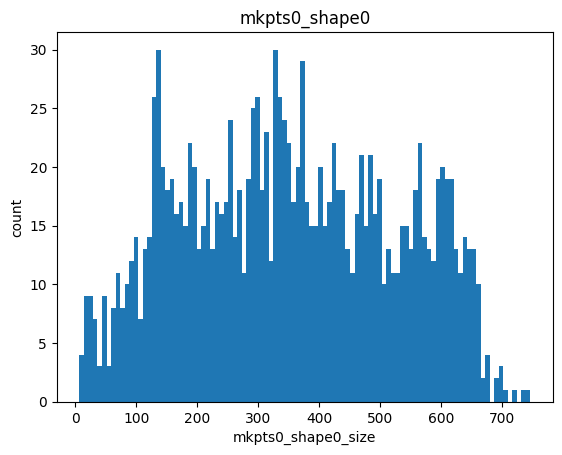

In [2]:
from matplotlib import pyplot as plt

mkpts0_shape0 = []
for data in dataset:
    mkpts0_shape0.append(data['mkpts0'].shape[0])

# 可视化mkpts0_shape0
plt.figure()
plt.title('mkpts0_shape0')
plt.xlabel('mkpts0_shape0_size')
plt.ylabel('count')
plt.hist(mkpts0_shape0, bins=100)
plt.show()

In [3]:
random.seed(20231223)
torch.manual_seed(20231223)
torch.cuda.manual_seed(20231223)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [4]:
num_sample = 300
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))

In [5]:
net = Mkpts_Reg_Model(num_sample=num_sample, mode='6d').to(device)
net.train()

L2 = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5)

Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint
Weights of ConvNeXtV2 not initialized from pretrained model: ['head.weight', 'head.bias']
size mismatch for stages.0.0.grn.gamma: copying a param with shape torch.Size([1, 1, 1, 1, 1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1, 1, 768]).
size mismatch for stages.0.0.grn.beta: copying a param with shape torch.Size([1, 1, 1, 1, 1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1, 1, 768]).
size mismatch for stages.0.1.grn.gamma: copying a param with shape torch.Size([1, 1, 1, 1, 1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1, 1, 768]).
size mismatch for stages.0.1.grn.beta: copying a param with shape torch.Size([1, 1, 1, 1, 1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1, 1, 768]).
size mismatch for stages.0.2.grn.gamma: copying a param with shape torch.Size([1, 1, 1, 1, 1, 768]) from check

KeyboardInterrupt: 

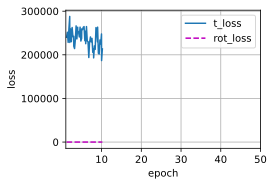

In [6]:
num_epochs = 100
model_type = 'relative_r-gt_t'

animator = Animator(xlabel='epoch', ylabel='loss',
                    xlim=[1, num_epochs],
                    legend=['t_loss', 'rot_loss'])

for epoch in range(1, num_epochs + 1):
    for i, batch in enumerate(train_dataloader):
        # if i == 1: break

        batch_K0 = []
        batch_K1 = []
        batch_pose0 = []
        batch_pose1 = []
        batch_mkpts0 = []
        batch_mkpts1 = []
        batch_pre_K = []
        batch_img0 = []
        batch_img1 = []

        for data in batch:
            batch_K0.append(data['K0'])
            batch_K1.append(data['K1'])
            # print(data['pose0'].shape)
            if data['pose0'].shape[0] == 3:
                data['pose0'] = np.vstack((data['pose0'], np.array([0, 0, 0, 1])))
            if data['pose1'].shape[0] == 3:
                data['pose1'] = np.vstack((data['pose1'], np.array([0, 0, 0, 1])))
            batch_pose0.append(data['pose0'])
            batch_pose1.append(data['pose1'])
            batch_mkpts0.append(data['mkpts0'])
            batch_mkpts1.append(data['mkpts1'])
            batch_pre_K.append(data['pre_K'])
            batch_img0.append(data['img0'])
            batch_img1.append(data['img1'])

        batch_K0 = torch.from_numpy(np.stack(batch_K0, axis=0)).float().to(device)
        batch_K1 = torch.from_numpy(np.stack(batch_K1, axis=0)).float().to(device)

        if model_type == 'gt':
            batch_pose0 = torch.from_numpy(np.stack(batch_pose0, axis=0)).float()
            batch_pose1 = torch.from_numpy(np.stack(batch_pose1, axis=0)).float()

            gt_rot = batch_pose1[:, :3, :3].to(device)
            gt_t = batch_pose1[:, :3, 3].to(device)
        elif model_type == 'relative':
            batch_pose0 = np.stack(batch_pose0, axis=0)
            batch_pose1 = np.stack(batch_pose1, axis=0)
            batch_relative_pose = np.matmul(batch_pose1, np.linalg.inv(batch_pose0))
            batch_relative_pose = torch.from_numpy(batch_relative_pose).float()

            gt_rot = batch_relative_pose[:, :3, :3].to(device)
            gt_t = batch_relative_pose[:, :3, 3].to(device)
        elif model_type == 'relative_r-gt_t':
            batch_pose0 = np.stack(batch_pose0, axis=0)
            batch_pose1 = np.stack(batch_pose1, axis=0)
            batch_relative_pose = np.matmul(batch_pose1, np.linalg.inv(batch_pose0))
            batch_relative_pose = torch.from_numpy(batch_relative_pose).float()
            batch_pose1 = torch.from_numpy(batch_pose1).float()


            gt_rot = batch_relative_pose[:, :3, :3].to(device)
            gt_t = batch_pose1[:, :3, 3].to(device)

        batch_mkpts0 = torch.from_numpy(np.stack(batch_mkpts0, axis=0)).float().to(device)
        batch_mkpts1 = torch.from_numpy(np.stack(batch_mkpts1, axis=0)).float().to(device)

        batch_pre_K = torch.from_numpy(np.stack(batch_pre_K, axis=0)).float().to(device)

        batch_img0 = torch.from_numpy(np.stack(batch_img0, axis=0)).float()
        batch_img1 = torch.from_numpy(np.stack(batch_img1, axis=0)).float()
        batch_img0 = batch_img0.permute(0, 3, 2, 1).to(device)
        batch_img1 = batch_img1.permute(0, 3, 2, 1).to(device)

        pre_t, pre_rot = net(batch_mkpts0, batch_mkpts1, batch_img0, batch_img1)

        t_loss = L2(gt_t, pre_t)
        rot_loss = geodesic_distance(gt_rot, pre_rot)

        loss = t_loss + rot_loss
        # loss = t_loss
        # loss = rot_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % (len(train_dataloader) // 5) == 0 or i == len(train_dataloader) - 1:
            # animator.add(epoch + (i + 1) / len(train_dataloader),
            #             (t_loss.item(), rot_loss.item()))
            print(f'epoch: {epoch}, t_loss: {t_loss.item()}, rot_loss: {rot_loss.item()}, loss: {loss.item()}')

In [ ]:
# 保存模型
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")
torch.save(net, f'./weights/{model_type}-{net.mode}-{num_sample}-{dt_string}-{loss:.4f}.pth')
print(f'{model_type}-{net.mode}-{num_sample}-{dt_string}-{loss:.4f}.pth')

relative_r-gt_t-6d-300-2024-04-07-15-35-46-0.4098.pth
